In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import fasttext
import spacy
from string import punctuation
from sklearn import metrics
import pickle as pkl
from sklearn.model_selection import ParameterGrid
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor
import itertools
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

# python -m spacy download en_core_web_trf

In [3]:
def process_text(text, nlp):
    stopwords = nlp.Defaults.stop_words
    doc = nlp(text.lower())
    return " ".join([token.lemma_ for token in doc if (token not in stopwords and token.text not in punctuation)])


def text_preprocessing(x):
    nlp = spacy.load('en_core_web_trf', disable=["ner"])
    return x.apply(lambda text: process_text(text, nlp))


def convert_emotions(df):
    y = []
    for i in range(10):
        y.append((df.iloc[:,i] + df.iloc[:,i +10]) / 2)
    matrix = []
    for j in range(len(y[0])):
        row = []
        for i in range(10):
            row.append(y[i][j])
        matrix.append(row)
    return pd.DataFrame(matrix, columns=['joy', 'trust', 'anticipation', 'surprise', 'fear', 'sadness', 'disgust', 'anger', 'valence', 'arousal'])


def load_data(files=None):
    if files is None:
        files = ['train.xlsx', 'dev.xlsx', 'test.xlsx']
    data = []
    for file in files:
        df = pd.read_excel(file)
        df = df.dropna()
        x = text_preprocessing(df['text'])
        y = convert_emotions(df.iloc[:, 2:])
        data.append(x)
        data.append(y)
    return data


def text_to_vector(model, x):
    return np.stack(x.apply(lambda txt: model.get_sentence_vector(txt)))

def load_orginal_y(files=None):
    if files is None:
        files = ['train.xlsx', 'dev.xlsx', 'test.xlsx']
    data = []
    for file in files:
        df = pd.read_excel(file)
        df = df.dropna()
        y = df.iloc[:, 2:]
        data.append(y)
    return data

In [4]:
def make_labels_for_value(row, tag, value, columns):
    if value > 0:
        return ['__label__'+label for label in columns[list(row[1:] >= value)] + str(tag)]
    else:
        return ['__label__'+label for label in columns[list(row[1:] <= value)] + str(tag)]

def make_list(columns, row):
    l = list()
    for tag, val in zip(['_neg',''],[-1, 1]):
        l.extend(make_labels_for_value(row, tag, val, columns))
    return l

In [ ]:
x_train, y_train, x_dev, y_dev, x_test, y_test = load_data()

In [5]:
df_train = pd.concat([x_train, y_train], axis=1)
df_dev = pd.concat([x_dev, y_dev], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)

In [6]:
with open('text.train', 'w+', encoding='utf-8') as f:
    df_train.apply(lambda row: f.write(' '.join(make_list(df_train.columns[1:], row)) + ' ' + row['text'] + '\n'), axis=1)

In [7]:
with open('text.dev', 'w+', encoding='utf-8') as f:
    df_dev.apply(lambda row: f.write(' '.join(make_list(df_dev.columns[1:], row)) + ' ' + row['text'] + '\n'), axis=1)

In [45]:
#model = fasttext.train_supervised(input="text.train", pretrainedVectors='wiki-news-300d-1M.vec', autotuneValidationFile='text.dev', dim=300, wordNgrams=3)
#model.save_model('best_model.bin')

In [ ]:
model = fasttext.load_model('best_model.bin')

In [53]:
x_train_vec = text_to_vector(model, x_train)
x_dev_vec = text_to_vector(model, x_dev)
x_test_vec = text_to_vector(model, x_test)

In [54]:
data = x_test_vec, y_train, x_dev_vec, y_dev, x_train_vec, y_test

with open('processed_data.pickle', 'wb') as f:
    pkl.dump(data, f)

In [6]:
param_grid = [
              {'C': [0.1,1,10,100],
              'gamma': [0.1,1,10,100,300],
              'kernel': ['rbf']}, 
              {'C': [0.1,1,10,100],
              'kernel': ['linear']},
              {'C': [0.1,1,10,100],
              'kernel': ['poly'],
              'degree':[2,3,5]}
              ]

best_score = 0
best_params = None

for sets_of_params in param_grid:
    keys, values = zip(*sets_of_params.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    for permuatation in permutations_dicts:
        ml = svm.SVR(**permuatation)
        moc = MultiOutputRegressor(ml).fit(x_train_vec, y_train)

        score = moc.score(x_dev_vec, y_dev)
        if score > best_score:
            best_score = score
            best_params = permuatation


print('Best validation score:', best_score, ' Best params:', best_params)

Best validation score: 0.1725028499681128  Best params: {'C': 1, 'gamma': 100, 'kernel': 'rbf'}


In [7]:
ml_svm = svm.SVR(**best_params)
moc_svm = MultiOutputRegressor(ml_svm).fit(x_train_vec, y_train)

In [10]:
with open('svm_model.pickle', 'wb') as f:
    pkl.dump(moc_svm, f)

In [ ]:
param_grid = [
              {'solver': ['sgd'],
              'activation': ['identity'],
              'random_state': [42,0,420,7],
              'max_iter': [100000],
              'learning_rate': ['invscaling'],
              'learning_rate_init': [0.2, 0.1, 0.03, 0.001, 0.003, 0.0001, 0.0003]},
              {'solver': ['sgd'],
              'activation': ['relu'],
              'random_state': [42,0,420,7],
              'max_iter': [100000],
              'learning_rate': ['invscaling'],
              'learning_rate_init': [1, 0.3, 0.2, 0.1, 0.03, 0.001, 0.003, 0.0001, 0.0003]},
              {'solver': ['adam'],
              'activation': ['identity', 'logistic', 'tanh', 'relu'], 
              'random_state': [42,0,420,7],
              'max_iter': [1000000],
              'learning_rate_init': [1, 0.3, 0.1, 0.03, 0.01, 0.0003, 0.0001, 0.00003, 0.00001, 0.000003, 0.000001, 0.0000003, 0.0000001, 0.00000003, 0.00000001]}
              ]

best_score = 0
best_params = None

for sets_of_params in param_grid:
    keys, values = zip(*sets_of_params.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    for permuatation in permutations_dicts:
        ml = MLPRegressor(**permuatation)
        moc = MultiOutputRegressor(ml).fit(x_train_vec, y_train)

        score = moc.score(x_dev_vec, y_dev)
        if score > best_score:
            best_score = score
            best_params = permuatation


print('Best validation score:', best_score, ' Best params:', best_params)

In [5]:
ml_NN = MLPRegressor(**best_params)
moc_NN = MultiOutputRegressor(ml_NN).fit(x_train_vec, y_train)

In [7]:
with open('NN_model.pickle', 'wb') as f:
    pkl.dump(moc_NN, f)

In [ ]:
param_grid = [
              {
              'splitter': ['best', 'random'],
              'criterion': ['squared_error','friedman_mse'],
              'max_depth': [None,1,2,3,4,5],
              'ccp_alpha': [0.0,0.003,0.01,0.03],
              'random_state': [42,0,420,7],
              'max_features': ['auto', 'sqrt', 'log2']
              }
              ]


best_score = 0
best_params = None

for sets_of_params in param_grid:
    keys, values = zip(*sets_of_params.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    for permuatation in permutations_dicts:
        ml = DecisionTreeRegressor(**permuatation)
        moc = MultiOutputRegressor(ml).fit(x_train_vec, y_train)

        score = moc.score(x_dev_vec, y_dev)
        if score > best_score:
            best_score = score
            best_params = permuatation


print('Best validation score:', best_score, ' Best params:', best_params)

In [8]:
ml_DT = DecisionTreeRegressor(**best_params)
moc_DT = MultiOutputRegressor(ml_DT).fit(x_train_vec, y_train)

In [9]:
with open('DT_model.pickle', 'wb') as f:
    pkl.dump(moc_DT, f)

In [ ]:
######################################################

In [5]:
with open('processed_data.pickle', 'rb') as f:
    data = pkl.load(f)

x_test_vec, y_train, x_dev_vec, y_dev, x_train_vec, y_test = data 

In [6]:
with open('svm_model.pickle', 'rb') as f:
    moc_svm = pkl.load(f)

In [7]:
errors = []
y_pred=moc_svm.predict(x_test_vec)
for idx in range(y_test.shape[1]):
    test_accuracy=metrics.r2_score(y_test.iloc[:, idx],y_pred[:, idx])
    errors.append(test_accuracy)

[0.22645339314685775,
 0.11851743438535434,
 0.012898307892732719,
 -0.056318720941648026,
 -0.01662426522727989,
 0.07465880673287562,
 0.14998690870823916,
 0.25270330479125847,
 0.4244042568044425,
 0.08251151121270694]

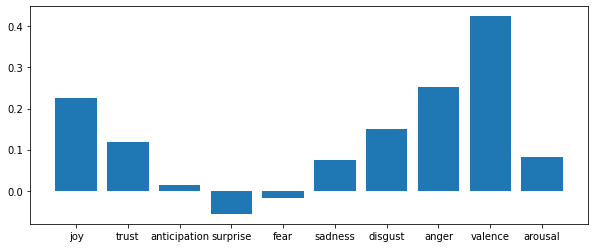

In [8]:
f = plt.figure()
f.set_figwidth(10)
plt.bar(y_train.columns,errors)
errors

In [9]:
with open('NN_model.pickle', 'rb') as f:
    moc_NN = pkl.load(f)

In [10]:
errors = []
y_pred=moc_NN.predict(x_test_vec)
for idx in range(y_test.shape[1]):
    test_accuracy=metrics.r2_score(y_test.iloc[:, idx],y_pred[:, idx])
    errors.append(test_accuracy)

[0.20947464837965635,
 0.16472601748423954,
 0.04459581359841869,
 0.02607526482911049,
 0.02619383028375588,
 0.13534597355793376,
 0.14076414716575392,
 0.2661000287065661,
 0.4457480296601163,
 0.07427640080697562]

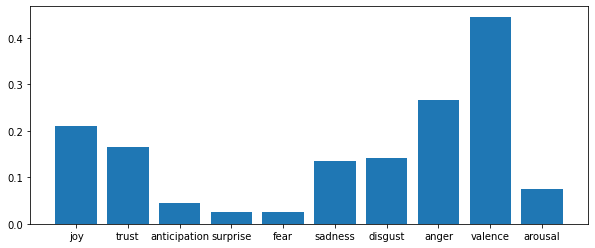

In [11]:
f = plt.figure()
f.set_figwidth(10)
plt.bar(y_train.columns,errors)
errors

In [12]:
with open('DT_model.pickle', 'rb') as f:
    moc_DT = pkl.load(f)

In [13]:
errors = []
y_pred=moc_DT.predict(x_test_vec)
for idx in range(y_test.shape[1]):
    test_accuracy=metrics.r2_score(y_test.iloc[:, idx],y_pred[:, idx])
    errors.append(test_accuracy)

[0.21240783586327816,
 0.14525385425005877,
 0.027041518206038062,
 0.027816464495310167,
 0.00229129972707498,
 0.09717948086472838,
 0.12996113537356835,
 0.2050163416852736,
 0.3302789044838432,
 0.008298892875231778]

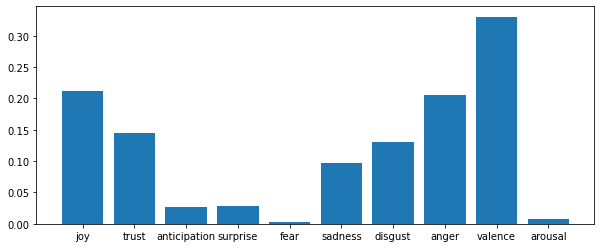

In [14]:
f = plt.figure()
f.set_figwidth(10)
plt.bar(y_train.columns,errors)
errors

In [15]:
y_test_org = load_orginal_y(['test.xlsx'])[0]
y_test_org_x = (y_test_org.iloc[:,10:]).set_axis(['joy', 'trust', 'anticipation', 'surprise', 'fear', 'sadness', 'disgust', 'anger', 'valence', 'arousal'],axis=1)
y_test_org_y = (y_test_org.iloc[:,:10]).set_axis(['joy', 'trust', 'anticipation', 'surprise', 'fear', 'sadness', 'disgust', 'anger', 'valence', 'arousal'],axis=1)
y_pred_test_org = pd.concat([y_test_org_x, y_test_org_y])
y_true_test_org = pd.concat([y_test_org_y, y_test_org_x])

In [16]:
r2_annotator_test = metrics.r2_score(y_true_test_org, y_pred_test_org)

In [17]:
errors = []
for idx in range(y_test.shape[1]):
    test_accuracy=metrics.r2_score(y_true_test_org.iloc[:, idx],y_pred_test_org.iloc[:, idx])
    errors.append(test_accuracy)

[0.3716978437812367,
 0.4041139644819215,
 -0.006500719878375749,
 0.04375590029730436,
 0.36181960525773615,
 0.2036371391218077,
 0.11525210721327805,
 0.47416490965991287,
 0.5892996603216125,
 0.11758528405433777]

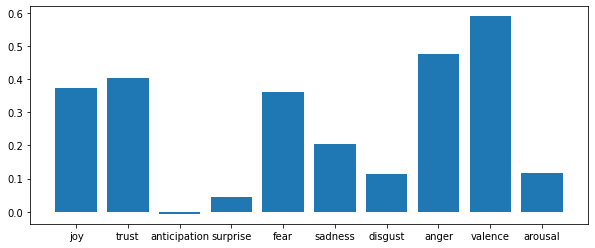

In [18]:
f = plt.figure()
f.set_figwidth(10)
plt.bar(y_train.columns,errors)
errors

In [19]:
y_train_org, y_dev_org, y_test_org = load_orginal_y()

In [20]:
y_org_all = pd.concat([y_train_org, y_dev_org, y_test_org])
y_org_x = (y_org_all.iloc[:,10:]).set_axis(['joy', 'trust', 'anticipation', 'surprise', 'fear', 'sadness', 'disgust', 'anger', 'valence', 'arousal'],axis=1)
y_org_y = (y_org_all.iloc[:,:10]).set_axis(['joy', 'trust', 'anticipation', 'surprise', 'fear', 'sadness', 'disgust', 'anger', 'valence', 'arousal'],axis=1)
y_pred_org = pd.concat([y_org_y, y_org_x])
y_true_org = pd.concat([y_org_x, y_org_y])

In [21]:
errors = []
for idx in range(y_test.shape[1]):
    test_accuracy=metrics.r2_score(y_true_org.iloc[:, idx], y_pred_org.iloc[:, idx])
    errors.append(test_accuracy)

[0.3454115630322796,
 0.4178430192791186,
 0.056371893648730964,
 -0.06958635456987672,
 0.39844109688246954,
 0.17138128553896503,
 0.20355129412837758,
 0.48397849301816986,
 0.6133621587501158,
 0.16296089606896869]

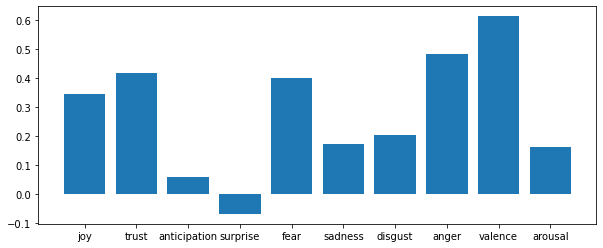

In [22]:
f = plt.figure()
f.set_figwidth(10)
plt.bar(y_train.columns,errors)
errors

In [23]:
r2_annotator_all = metrics.r2_score(y_pred_org, y_true_org)

In [24]:
r2_svm = moc_svm.score(x_test_vec, y_test)

In [25]:
r2_NN = moc_NN.score(x_test_vec, y_test)

In [26]:
r2_DT = moc_DT.score(x_test_vec, y_test)

0.11855457278244055

[0.12691909375055394,
 0.11855457278244055,
 0.15333001544725267,
 0.26748256943107723,
 0.2783715345777319]

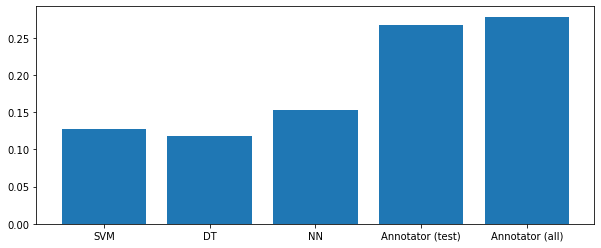

In [27]:
r2_values = [r2_svm, r2_DT, r2_NN, r2_annotator_test, r2_annotator_all]
method_names = ['SVM', 'DT', 'NN', 'Annotator (test)', 'Annotator (all)']

f = plt.figure()
f.set_figwidth(10)
plt.bar(method_names, r2_values)
r2_values